In [83]:
import pandas as pd
import numpy as np
import yfinance as yf
from matplotlib import pyplot as plt

### Gathering Data for Pricing Brent Oil Futures
We are gathering US Brent Crude Oil Futures

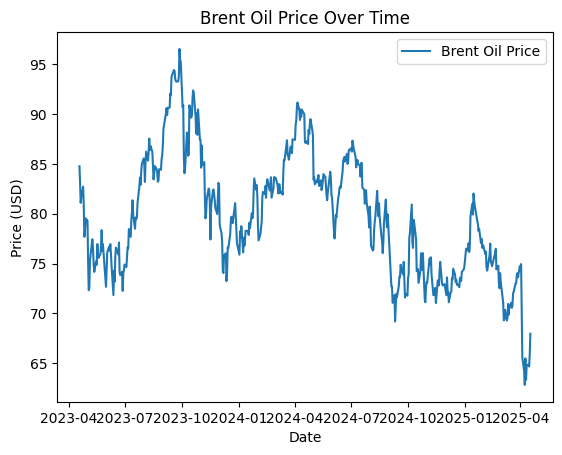

In [84]:
brent_oil = yf.Ticker("BZ=F")
brent_oil_data = brent_oil.history(period="2y", interval="1d")
brent_oil_data['Log Returns'] = np.log(brent_oil_data['Close'] / brent_oil_data['Close'].shift(1))
df = pd.DataFrame(brent_oil_data['Close'],brent_oil_data['Log Returns'])
plt.plot(brent_oil_data.index, brent_oil_data['Close'], label='Brent Oil Price')
plt.title('Brent Oil Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

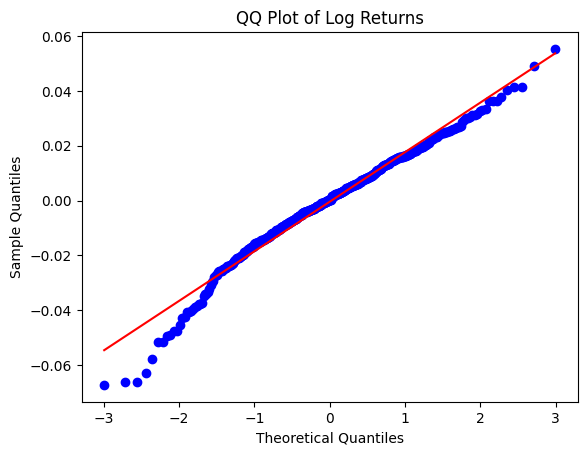

In [85]:
from scipy.stats import probplot
probplot(brent_oil_data['Log Returns'].dropna(), dist="norm", plot=plt)
plt.title('QQ Plot of Log Returns')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()


#### Calculating historical volatility

In [86]:
annualized_volatility = brent_oil_data['Log Returns'].std() * np.sqrt(252)
print(f"Annualized Volatility: {annualized_volatility:.2%}")

Annualized Volatility: 28.91%


### We need a methodogoly to calculate the rolling average of an asset.

In [88]:
def calc_rolling_avg_price(data):
    data['Rolling Avg Price'] = data['Close'].expanding().mean()
    return data

updated_df = calc_rolling_avg_price(brent_oil_data)

<Axes: xlabel='Date'>

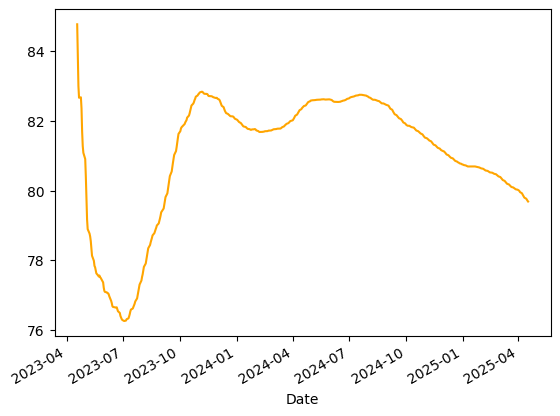

In [89]:
updated_df['Rolling Avg Price'].plot(label='Rolling Avg Price', color='orange')

### BAPM Pricing Functions

In [90]:
# the following function is used to create a binomial tree for American options
def binomial_tree_regular(S_0,sigma,delta_t,N):
    tree = np.zeros((N+1, N+1,))
    u = np.exp(sigma * np.sqrt(delta_t))
    d = np.exp(-sigma * np.sqrt(delta_t))
    for i in range(N+1):
        for j in range(i+1):
            tree[i, j] = S_0 * (u**j) * (d**(i-j))
    return tree
def generate_asian_nodes(S_0, N, p, u, d):
    # helper function to generate nodes for Asian options
    nodes = {}
    # initial node has time 0, 0 up moves and initial price S_0
    # this also has a probability of 1.0
    nodes[(0, 0, S_0)] = 1.0 
    for t in range(1, N+1):
        new_nodes = {}
        # looping through all the existing nodes in the tree
        for (prev_t, up_moves, cum_sum), prob in nodes.items():
            down_moves = prev_t - up_moves
            # calculating the new up and down prices
            S_up = S_0 * (u ** (up_moves + 1)) * (d ** down_moves)
            S_down = S_0 * (u ** up_moves) * (d ** (down_moves + 1))
            #updating new nodes with the new up and down prices
            key_up = (t, up_moves + 1, cum_sum + S_up)
            new_nodes[key_up] = new_nodes.get(key_up, 0) + prob * p
            key_down = (t, up_moves, cum_sum + S_down)
            new_nodes[key_down] = new_nodes.get(key_down, 0) + prob * (1 - p)
        nodes = new_nodes
    return nodes

def prob_p(r_f, delta_t, sigma):
    u = np.exp(sigma * np.sqrt(delta_t))
    d = np.exp(-sigma * np.sqrt(delta_t))
    p = (np.exp(r_f * delta_t) - d) / (u - d)
    return p,u,d
def asian_option_valuation(S_0, K, r_f, sigma, T, N,option_type):
    delta_t = T / N
    p,u,d = prob_p(r_f, delta_t, sigma)
    tree_nodes = generate_asian_nodes(S_0, N, p, u, d)
    option_value = 0
    for (t,up_moves,cum_sum),prob in tree_nodes.items():
        # calculating average price at each node
        avg_price = cum_sum / (N + 1)
        if option_type == 'call':
            option_value += prob * np.maximum(avg_price - K, 0)
        elif option_type == 'put':
            option_value += prob * np.maximum(K - avg_price, 0)
    option_value *= np.exp(-r_f * T)
    return option_value


### Monte Carlo Simulation

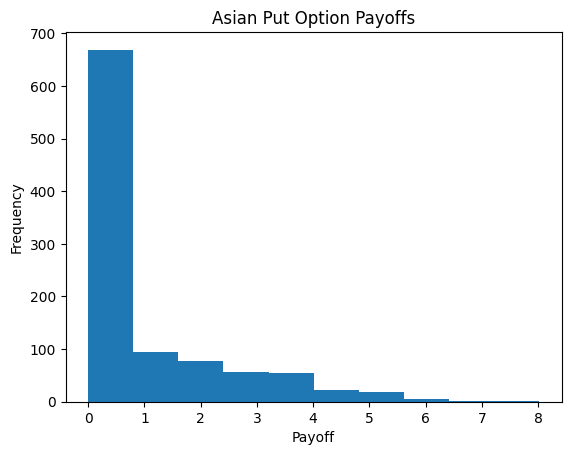

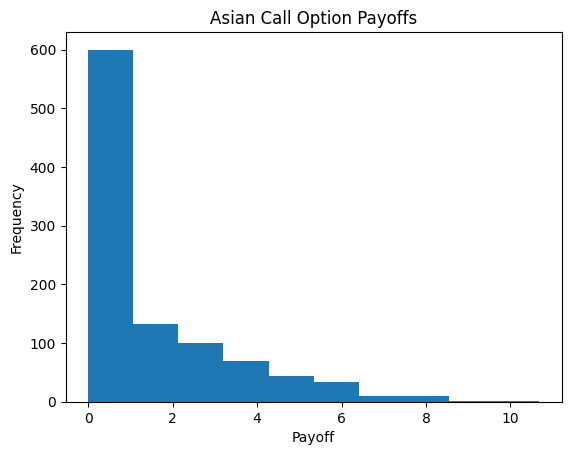

Asian Put Option Price: 0.91
Asian Call Option Price: 1.40


In [91]:
def price_asian_put_monte_carlo(S_0,K,r,sigma,T,n_steps,n_sim):
    dt = T/ n_steps
    payoffs = []
    for x in range(n_sim):
        path = [S_0]
        for i in range(n_steps):
            normal_dist = np.random.normal()
            path.append(path[-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * normal_dist))
        avg_price = np.mean(path)
        payoff = max(K - avg_price, 0)
        payoffs.append(payoff * np.exp(-r * T))
    plt.hist(payoffs)
    plt.title('Asian Put Option Payoffs')
    plt.xlabel('Payoff')
    plt.ylabel('Frequency')
    plt.show()
    return np.mean(payoffs)
def price_asian_call_monte_carlo(S0, K, r, sigma, T, n_steps, n_sim):
    dt = T / n_steps
    payoffs = []

    for _ in range(n_sim):
        path = [S0]
        for _ in range(n_steps):
            z = np.random.normal()
            St = path[-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z)
            path.append(St)
        avg_price = np.mean(path)
        payoff = max(avg_price - K, 0) * np.exp(-r * T)
        payoffs.append(payoff)
    plt.hist(payoffs)
    plt.title('Asian Call Option Payoffs')
    plt.xlabel('Payoff')
    plt.ylabel('Frequency')
    plt.show()

    return np.mean(payoffs)

put  = price_asian_put_monte_carlo(100, 100, 0.01, 0.05, 1, 10000, 1000)
call  = price_asian_call_monte_carlo(100, 100, 0.01, 0.05, 1, 10000, 1000)
print(f"Asian Put Option Price: {put:.2f}")
print(f"Asian Call Option Price: {call:.2f}")

### To hedge our Asian Options, we need to use the Greeks.

However, for our example, since we are not working with European options, we need to take a different approach to pricing greeks.

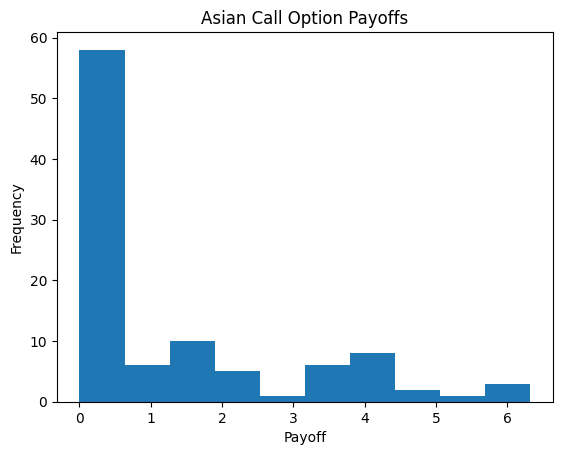

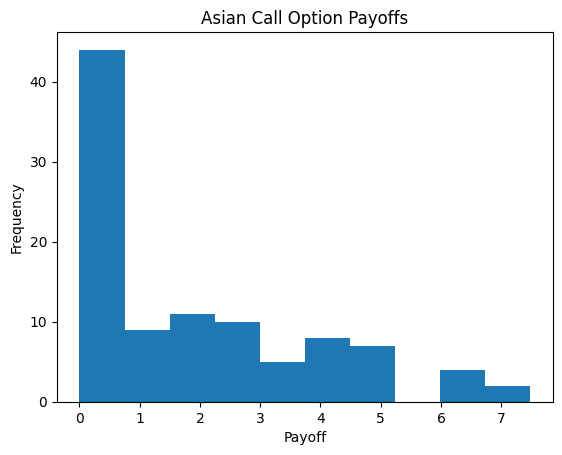

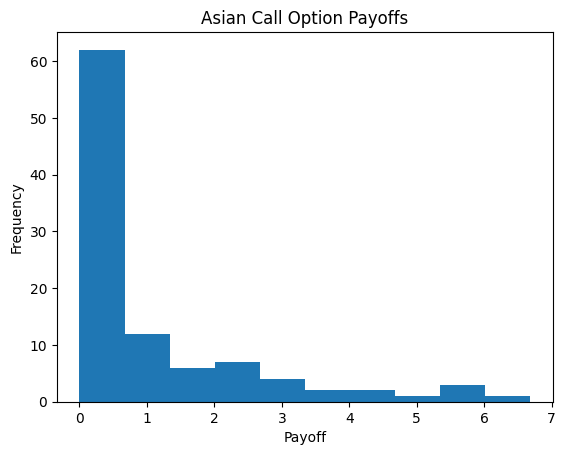

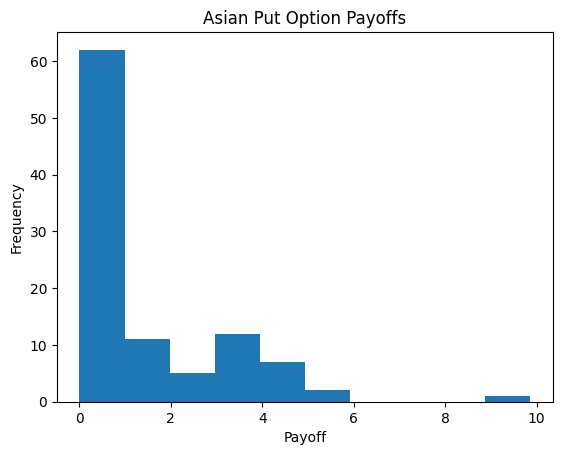

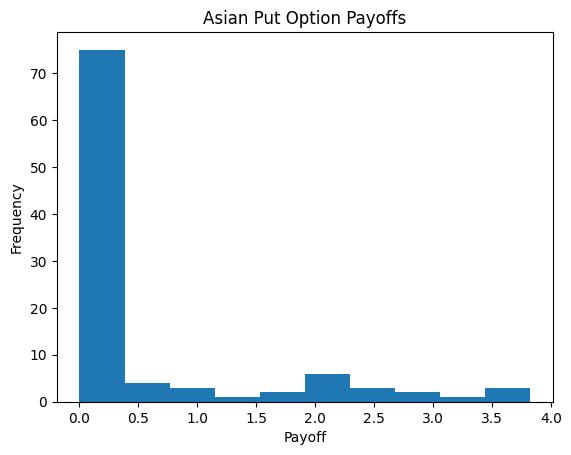

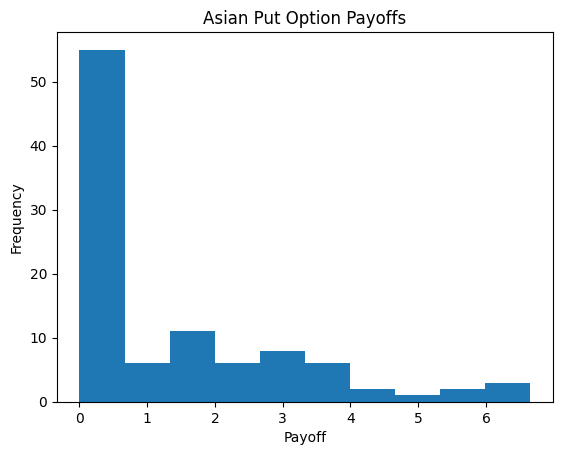

Call Option Delta: 0.4455, Gamma: 0.3589
Put Option Delta: -0.3953, Gamma: -0.6531


In [93]:
def calculate_price_greeks(S0, K, r, sigma, T, n_steps, n_sim,option_type,epsilon=1):
    if option_type == 'call':
        price = price_asian_call_monte_carlo(S0, K, r, sigma, T, n_steps, n_sim)
        call_price_up = price_asian_call_monte_carlo(S0 + epsilon, K, r, sigma, T, n_steps, n_sim)
        call_price_down = price_asian_call_monte_carlo(S0 - epsilon, K, r, sigma, T, n_steps, n_sim)
        delta = (call_price_up - call_price_down) / (2 * epsilon)
        gamma = (call_price_up - 2 * price + call_price_down) / (epsilon ** 2)
    elif option_type == 'put':
        price = price_asian_put_monte_carlo(S0, K, r, sigma, T, n_steps, n_sim)
        put_price_up = price_asian_put_monte_carlo(S0 + epsilon, K, r, sigma, T, n_steps, n_sim)
        put_price_down = price_asian_put_monte_carlo(S0 - epsilon, K, r, sigma, T, n_steps, n_sim)
        delta = (put_price_up - put_price_down) / (2 * epsilon)
        gamma = (put_price_up - 2 * price + put_price_down) / (epsilon ** 2)
    return delta, gamma
delta_call, gamma_call = calculate_price_greeks(100, 100, 0.01, 0.05, 1, 1000, 100,'call')
delta_put, gamma_put = calculate_price_greeks(100, 100, 0.01, 0.05, 1, 1000, 100,'put')
print(f"Call Option Delta: {delta_call:.4f}, Gamma: {gamma_call:.4f}")
print(f"Put Option Delta: {delta_put:.4f}, Gamma: {gamma_put:.4f}")